# Exploratory Notebook: GAN for EEG Data Augmentation


**Overview:**
In this notebook, we:
1. Load preprocessed EEG data (63 channels, ~1001 timepoints per epoch).
2. Define a GAN architecture without conditional labels.
3. Train the GAN using a standard adversarial loss.
4. Visualize the training progress and generated EEG samples (both in time and frequency domains).

**Note:** This GAN does not incorporate class conditioning. It learns to generate EEG-like signals from noise.

**Team Contributions:**
- **Rahul:** Overall project integration, GAN implementation, and documentation.




In [1]:
# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import mne
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

# Configure matplotlib and seaborn
%matplotlib inline
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.2)

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# hyperparameter definition

latent_dim = 100
n_channels = 63

default_target_signal_len = 1001 # this is from data, but we usually take this dynamically
# when loading the data

batch_size = 64
learning_rate = 5e-5
num_epochs = 500 # should be increased if you're fully training this

### GAN architecture


In [4]:
class EEGGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_channels=63, target_signal_len=default_target_signal_len):
        super().__init__()
        self.n_channels = n_channels
        self.target_signal_len = target_signal_len

        # Compute base length and remainder for upsampling:
        self.base_length = target_signal_len // 8  # e.g., 1001 // 8 = 125
        remainder = target_signal_len - (self.base_length * 8)  # e.g., 1001 - 1000 = 1

        # Fully connected layer to project latent vector to a feature map of shape (256, base_length)
        self.fc = nn.Linear(latent_dim, 256 * self.base_length)

        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample: base_length -> base_length*2
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample: base_length*2 -> base_length*4
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.ConvTranspose1d(64, n_channels, kernel_size=4, stride=2, padding=1, output_padding=remainder),  # Upsample: base_length*4 -> target_signal_len
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, noise):
        x = self.fc(noise)
        x = x.view(x.size(0), 256, self.base_length)
        out = self.deconv_blocks(x)
        return out

class EEGDiscriminator(nn.Module):
    def __init__(self, n_channels=63, target_signal_len=default_target_signal_len):
        super().__init__()
        self.n_channels = n_channels
        self.target_signal_len = target_signal_len

        self.conv_blocks = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=4, stride=2, padding=1),  # target_signal_len -> target_signal_len/2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),           # -> target_signal_len/4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 1, kernel_size=4, stride=2, padding=1),            # -> target_signal_len/8
        )

    def forward(self, eeg):
        out = self.conv_blocks(eeg)
        # Global average pooling over the time dimension to obtain a scalar per sample
        return out.mean(dim=2)

In [7]:
# setting device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: mps


### Loading data and instantiating models

In [10]:
def load_all_preprocessed_data(preprocessed_root="./../data/preprocessed/", num_classes = 2):
    subject_folders = [d for d in os.listdir(preprocessed_root) if os.path.isdir(os.path.join(preprocessed_root, d))]
    all_data = []
    all_labels = []

    for subj in subject_folders:
        fif_path = os.path.join(preprocessed_root, subj, "preprocessed_epochs-epo.fif")
        if os.path.exists(fif_path):
            epochs = mne.read_epochs(fif_path, preload=True)
            data = epochs.get_data()
            events = epochs.events


            labels_int = events[:, 2]
            unique_codes = np.unique(labels_int)

            # If only one event code is found, randomly split epochs into two classes.
            if len(unique_codes) < 2:
                print(f"Subject {subj}: Only one event code found. Randomly splitting epochs into two classes.")
                n_epochs = data.shape[0]
                # Randomly shuffle indices and split into two halves.
                indices = np.arange(n_epochs)
                np.random.shuffle(indices)
                labels_int = np.zeros(n_epochs, dtype=int)
                split_idx = n_epochs // 2
                labels_int[indices[split_idx:]] = 1
            else:
                # If more than two codes, take only the first two
                if len(unique_codes) > 2:
                    unique_codes = unique_codes[:2]
                mapping = {unique_codes[0]: 0, unique_codes[1]: 1}
                labels_int = np.vectorize(lambda x: mapping.get(x, 0))(labels_int)

            # One-hot encode the labels
            labels_onehot = np.zeros((len(labels_int), num_classes))
            labels_onehot[np.arange(len(labels_int)), labels_int] = 1

            all_data.append(data)
            all_labels.append(labels_onehot)
        else:
            print(f"File {fif_path} not found. Skipping subject {subj}.")

    if len(all_data) == 0:
        raise RuntimeError("No preprocessed data found.")

    # Concatenate data across subjects
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print("Loaded preprocessed EEG data shape:", all_data.shape)
    print("Loaded labels shape:", all_labels.shape)
    return all_data, all_labels

# Load data
all_data, all_labels = load_all_preprocessed_data()
print("All data shape:", all_data.shape)

# Convert data to torch tensor (float32)
real_EEG = torch.from_numpy(all_data.astype(np.float32))
print("Torch EEG data shape:", real_EEG.shape)

# Update target_signal_len based on real data
target_signal_len = real_EEG.shape[2]
print("Target signal length from data:", target_signal_len)

# Re-instantiate models with updated target_signal_len
generator = EEGGenerator(latent_dim, n_channels, target_signal_len).to(device)
discriminator = EEGDiscriminator(n_channels, target_signal_len).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))

# Create DataLoader
dataset = TensorDataset(real_EEG)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/exploratory notebooks/../data/preprocessed/Sub42/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Subject Sub42: Only one event code found. Randomly splitting epochs into two classes.
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/exploratory notebooks/../data/preprocessed/Sub11/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Subject Sub11: Only one event code found. Randomly splitting epochs into two classes.
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/

### Training loop for GAN

In [11]:
criterion = nn.BCELoss()

def real_labels_tensor(size):
    return torch.ones(size, 1).to(device)

def fake_labels_tensor(size):
    return torch.zeros(size, 1).to(device)

G_losses = []
D_losses = []

print("Starting training of simple GAN...")

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    for i, (real_batch,) in enumerate(dataloader):
        real_batch = real_batch.to(device)
        current_batch_size = real_batch.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real EEG labels (target 1)
        real_targets = real_labels_tensor(current_batch_size)
        D_real = discriminator(real_batch)
        loss_real = criterion(D_real, real_targets)

        # Generate fake EEG
        noise = torch.randn(current_batch_size, latent_dim).to(device)
        fake_EEG = generator(noise)
        fake_targets = fake_labels_tensor(current_batch_size)
        D_fake = discriminator(fake_EEG.detach())
        loss_fake = criterion(D_fake, fake_targets)

        D_loss = loss_real + loss_fake
        D_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        # For generator, we want the discriminator to label the fake EEG as real (target 1)
        D_fake_for_G = discriminator(fake_EEG)
        G_loss = criterion(D_fake_for_G, real_targets)
        G_loss.backward()
        optimizer_G.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

print("Training complete.")

Starting training of simple GAN...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/500] | D_loss: 2.2811 | G_loss: 0.1591
Epoch [40/500] | D_loss: 3.0507 | G_loss: 0.0846
Epoch [60/500] | D_loss: 3.0724 | G_loss: 0.0907
Epoch [80/500] | D_loss: 3.1172 | G_loss: 0.0948
Epoch [100/500] | D_loss: 3.6088 | G_loss: 0.0577
Epoch [120/500] | D_loss: 3.9179 | G_loss: 0.0453
Epoch [140/500] | D_loss: 3.4077 | G_loss: 0.0782
Epoch [160/500] | D_loss: 4.7196 | G_loss: 0.0210
Epoch [180/500] | D_loss: 3.3080 | G_loss: 0.0858
Epoch [200/500] | D_loss: 4.1838 | G_loss: 0.0373
Epoch [220/500] | D_loss: 3.4817 | G_loss: 0.0801
Epoch [240/500] | D_loss: 6.7755 | G_loss: 0.0029
Epoch [260/500] | D_loss: 4.4930 | G_loss: 0.0298
Epoch [280/500] | D_loss: 4.3767 | G_loss: 0.0324
Epoch [300/500] | D_loss: 3.4358 | G_loss: 0.0844
Epoch [320/500] | D_loss: 4.6466 | G_loss: 0.0262
Epoch [340/500] | D_loss: 0.4872 | G_loss: 1.8558
Epoch [360/500] | D_loss: 0.3720 | G_loss: 2.3787
Epoch [380/500] | D_loss: 0.4030 | G_loss: 2.9188
Epoch [400/500] | D_loss: 0.3950 | G_loss: 2.2898
Epoc

### Visualisations

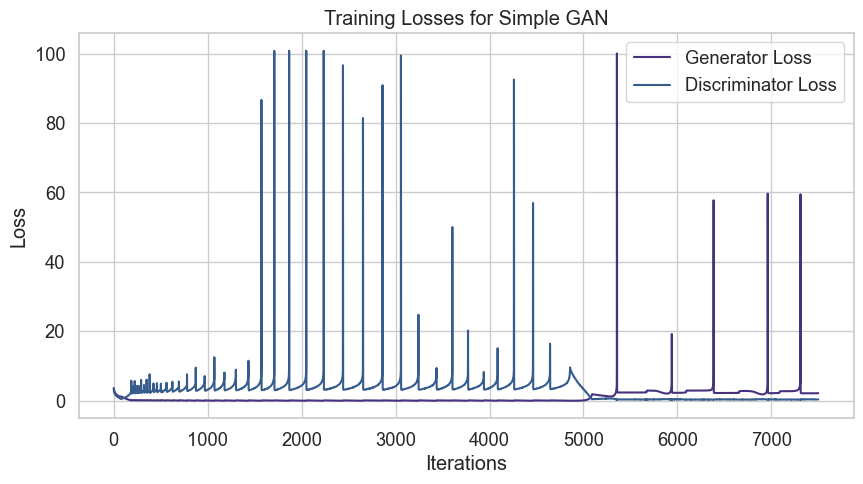

In [12]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Losses for Simple GAN")
plt.legend()
plt.show()

In [14]:
# Generation and vis of synthetic data

def generate_samples(generator, num_samples):
    noise = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        fake_samples = generator(noise)
    return fake_samples.cpu().numpy()

# Generate 4 samples
fake_samples = generate_samples(generator, 4)

/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_14222/3145843751.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize="small")


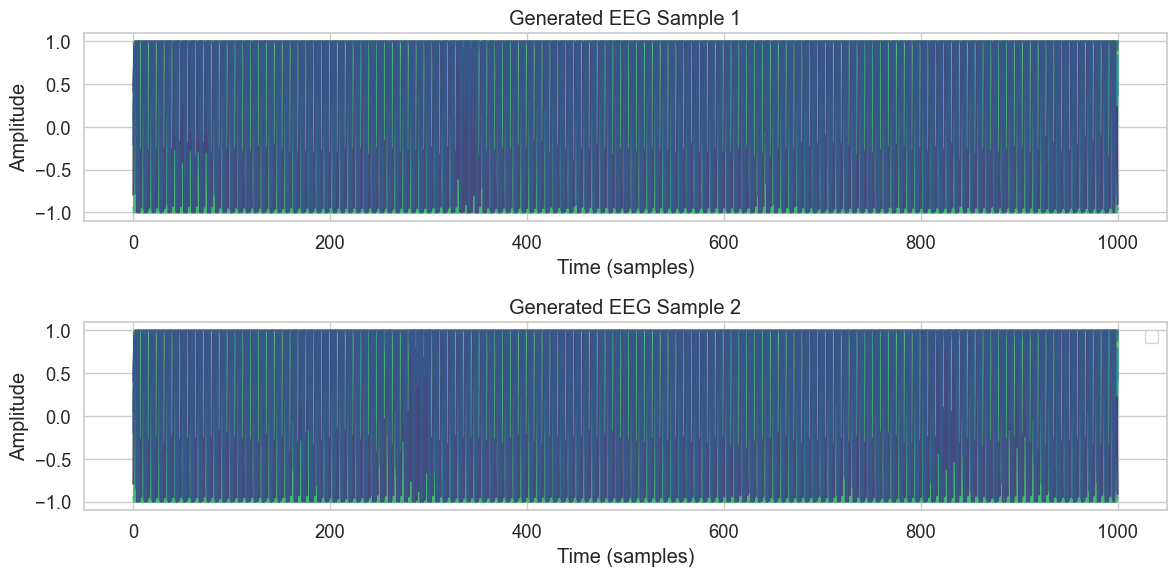

In [15]:
num_to_plot = 2
plt.figure(figsize=(12, 6))
for i in range(num_to_plot):
    plt.subplot(num_to_plot, 1, i+1)
    for ch in range(8):
        plt.plot(fake_samples[i, ch, :], label=f"Ch {ch}" if i == 0 else "", alpha=0.8)
    plt.title(f"Generated EEG Sample {i+1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.legend(loc="upper right", fontsize="small")
plt.show()

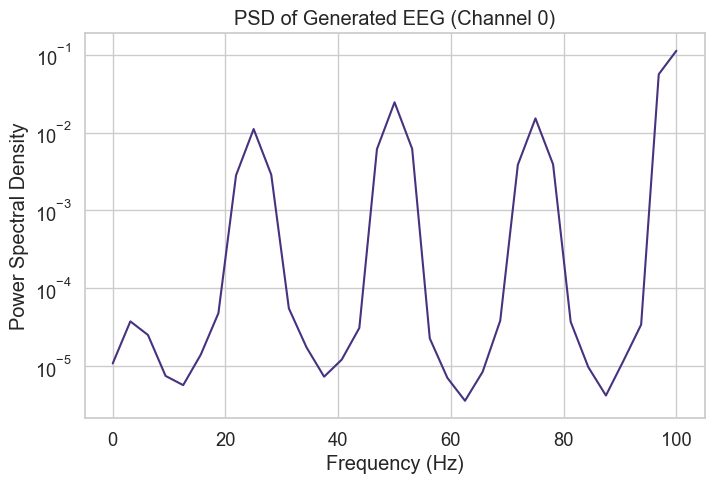

In [17]:
# PSD

fs_generated = 200  # Sampling frequency
sample_idx = 0
channel_idx = 0
signal_data = fake_samples[sample_idx, channel_idx, :]

freqs, psd = welch(signal_data, fs=fs_generated, nperseg=64)

plt.figure(figsize=(8,5))
plt.semilogy(freqs, psd)
plt.title("PSD of Generated EEG (Channel 0)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.show()